In [1]:
# Cell 1: imports & session
from models import Base, Video, VideoStatistic, Thumbnail, Caption, EntitySentiment
import os
import re
import requests
import subprocess

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from youtube_transcript_api import YouTubeTranscriptApi
import yt_dlp
from isodate import parse_duration

from sqlalchemy.dialects.postgresql import JSONB
from pgvector.sqlalchemy import Vector



# your ORM models; make sure this path is on PYTHONPATH


# load env vars
PGHOST     = os.environ["PGHOST"]
PGPORT     = os.environ["PGPORT"]
PGDATABASE = os.environ["PGDATABASE"]
PGUSER     = os.environ["PGUSER"]
PGPASSWORD = os.environ["PGPASSWORD"]
API_KEY    = os.environ["YOUTUBE_API_KEY"]
CHANNEL_ID = os.environ["CHANNEL_ID"]
CHANNEL_IDS = os.environ["CHANNEL_IDS"]

DATABASE_URL = (
    f"postgresql+psycopg2://{PGUSER}:{PGPASSWORD}"
    f"@{PGHOST}:{PGPORT}/{PGDATABASE}"
)

# create engine & session
engine = create_engine(DATABASE_URL, echo=False)
SessionLocal = sessionmaker(bind=engine)
session = SessionLocal()


In [3]:
# Cell 2: extract_text_from_vtt + fallback fetch_captions
# (This cell defines helper functions and does not need to change
#  to accommodate a list of CHANNEL_IDS. The changes for handling
#  multiple channels occur in the cell that *calls* these functions.)

import os # Make sure os is imported if not already
import re # Make sure re is imported
# Ensure youtube_transcript_api and yt_dlp are imported where fetch_captions is called or here
# from youtube_transcript_api import YouTubeTranscriptApi # (Example, usually imported in the calling cell)
# import yt_dlp # (Example, usually imported in the calling cell)


def extract_text_from_vtt(vtt_path):
    """Extracts captions as list of dicts with keys: text, start, duration."""
    captions, buffer = [], []
    timestamp_re = re.compile(
        r"(\d+):(\d{2}):(\d{2}\.\d+)\s-->\s(\d+):(\d{2}):(\d{2}\.\d+)"
    )
    # These variables will store the start and end of the current caption line being processed
    current_caption_start_time = None
    current_caption_end_time = None

    def flush_buffer(): # Renamed to avoid potential conflicts and clarify scope
        nonlocal buffer, current_caption_start_time, current_caption_end_time # Refer to the ones in extract_text_from_vtt
        if buffer and current_caption_start_time is not None and current_caption_end_time is not None:
            text = " ".join(buffer).strip()
            if text:
                duration = current_caption_end_time - current_caption_start_time
                if duration > 0: # Only add captions with positive duration
                    captions.append({
                        "text": text,
                        "start": current_caption_start_time,
                        "duration": duration
                    })
        buffer.clear()
        # Reset times after flushing for the next segment
        current_caption_start_time = None
        current_caption_end_time = None

    with open(vtt_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(("WEBVTT", "Kind:", "Language:")):
                continue
            
            match = timestamp_re.match(line)
            if match:
                flush_buffer() # Process any buffered text before starting a new timestamp
                h1, m1, s1, h2, m2, s2 = match.groups()
                current_caption_start_time = int(h1) * 3600 + int(m1) * 60 + float(s1)
                current_caption_end_time   = int(h2) * 3600 + int(m2) * 60 + float(s2)
                continue
            # If it's not a timestamp line, it's caption text (or metadata we ignore after first lines)
            buffer.append(re.sub(r"<.*?>", "", line)) # Remove VTT tags like <v Roger Bingham>
        
        flush_buffer() # Process any remaining text at the end of the file
    return captions

def fetch_captions(video_id: str):
    # This function uses the refined logic from our previous discussions
    # to handle both YouTubeTranscriptApi and yt_dlp.
    
    # 1. YouTubeTranscriptApi
    try:
        from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound, TranscriptsDisabled
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id) 
        target_transcript_obj = None
        try:
            target_transcript_obj = transcript_list.find_manually_created_transcript(['en', 'en-GB', 'en-US'])
        except NoTranscriptFound:
            try:
                target_transcript_obj = transcript_list.find_generated_transcript(['en', 'en-GB', 'en-US'])
            except NoTranscriptFound:
                pass 
        
        if target_transcript_obj:
            fetched_segments_list = target_transcript_obj.fetch()
            if isinstance(fetched_segments_list, list) and \
               all(isinstance(s, dict) and all(k in s for k in ['text', 'start', 'duration']) for s in fetched_segments_list):
                 return fetched_segments_list, "YouTubeTranscriptApi"
            else:
                # This case means .fetch() did not return the expected List[Dict]
                # print(f"Warning [{video_id}]: YouTubeTranscriptApi.fetch() returned unexpected segment format. Type: {type(fetched_segments_list)}. Content sample (if list): {str(fetched_segments_list[:2]) if isinstance(fetched_segments_list, list) else 'Not a list'}")
                # Fall through to yt_dlp if format is unusable
                pass # Fall through if format is not as expected
    
    except (NoTranscriptFound, TranscriptsDisabled):
        pass # Expected case, proceed to yt_dlp
    except Exception as e:
        # print(f"Info [{video_id}]: YouTubeTranscriptApi general error: {e} (Proceeding to yt_dlp)")
        pass

    # 2. yt_dlp fallback
    import yt_dlp # Ensure yt_dlp is imported
    # Use a temporary, unique name for VTT file.
    base_vtt_filename = f"{video_id}_temp_sub_dlp" # Made filename more specific
    
    # Clean up any potential old VTT files from previous runs with this base name
    for old_file in os.listdir('.'):
        if old_file.startswith(base_vtt_filename) and old_file.endswith((".vtt", ".en.vtt")):
            try:
                os.remove(old_file)
            except OSError: pass

    opts = {
        "skip_download": True,
        "writesubtitles": True,
        "writeautomaticsub": True,
        "subtitleslangs": ["en"], 
        "subtitlesformat": "vtt",
        "outtmpl": f"{base_vtt_filename}.%(ext)s", # yt-dlp adds lang like .en.vtt
        "quiet": True,
        "no_warnings": True,
        "ignoreerrors": True,
        "verbose": False,
    }
    
    download_error_code = 1 # Assume error initially
    try:
        with yt_dlp.YoutubeDL(opts) as ydl:
            download_error_code = ydl.download([f"https://www.youtube.com/watch?v={video_id}"])
    except Exception as e:
        # print(f"Info [{video_id}]: yt-dlp download raised exception: {e}")
        pass 

    actual_vtt_file_path = None
    if download_error_code == 0: # 0 means success for ydl.download
        possible_lang_suffixes = ['en', 'en-US', 'en-GB'] 
        for lang_suffix in possible_lang_suffixes:
            # The output template includes .%(ext)s where ext is the format, so it becomes .vtt
            # and yt-dlp inserts language before that. So, filename.lang.vtt
            potential_file = f"{base_vtt_filename}.{lang_suffix}.vtt"
            if os.path.exists(potential_file):
                actual_vtt_file_path = potential_file
                break
    
    if actual_vtt_file_path:
        try:
            caps = extract_text_from_vtt(actual_vtt_file_path)
            if caps: # Ensure caps is not empty
                return caps, "yt_dlp"
        except Exception as e:
            # print(f"Info [{video_id}]: Error processing VTT file {actual_vtt_file_path}: {e}")
            pass
        finally:
            try:
                os.remove(actual_vtt_file_path)
            except OSError: 
                pass
                
    return [], "none"

In [4]:
# Combined Cell: Fetch metadata, upsert video/stats/thumbnails,
#                fetch raw captions, merge to sentences, and insert merged captions
# NOW MODIFIED TO USE A LIST OF CHANNEL_IDS

import os
import re
import requests
from datetime import datetime, timedelta 

from sqlalchemy import delete, select
from sqlalchemy.exc import SQLAlchemyError

# Assuming these are in Cell 1 and models.py is correct:
# Make sure these are imported in your notebook, e.g., in Cell 1
# from models import Base, Video, VideoStatistic, Thumbnail, Caption 
# engine, SessionLocal, session # Your SQLAlchemy session
# API_KEY # Your YouTube Data API Key

from isodate import parse_duration

# --- List of Channel IDs to Process ---
CHANNEL_IDS = [
    "UC16niRr50-MSBwiO3YDb3RA", # BBC News
    "UCupvZG-5ko_eiXAupKpz1SQ", # CNN
    "UCNye-wNBqNL5ZzHSJj3l8Bg", # Al Jazeera English
    "UCXIJgqnII2ZOINSWNOGFThA", # Fox News
    "UCBi2mrWuNuyYy4gbM6fU18Q", # ABC News (US)
    "UCeY0bbntWzzVIHolqrQ9PQg", # NBC News
    "UCoMdktPbSTixXG0gYmhgXFQ", # Sky News (UK)
    "UCknLrEdhRCp1aegoMqRaCZg", # DW News (Deutsche Welle, Germany - English)
    "UCQfwfsi5VrQ8yKZ-UWmAEFg", # FRANCE 24 English
    "UC_gUM8rL-Lrg6O3adPW9K1g"  # WION (India - English)
]
# Max videos to fetch per channel in one run (be mindful of API quotas and processing time)
MAX_RESULTS_PER_CHANNEL = 5 # <<<< START WITH A SMALL NUMBER FOR TESTING (e.g., 1-5)

# --- Helper: Caption Merging Logic ---
# (This function is copied verbatim from your provided code)
SENTENCE_SPLIT_RE = re.compile(r'(?<=[\.\?\!])\s+')
MIN_SENTENCE_DURATION = 0.001 

def merge_raw_segments_to_sentences(raw_segments: list[dict], video_id_for_debug: str = "N/A") -> list[dict]:
    word_timeline = []
    for seg_idx, seg in enumerate(raw_segments):
        try:
            text = seg['text']
            start = float(seg['start'])
            duration = float(seg['duration'])
        except KeyError as e:
            print(f"Warning [{video_id_for_debug}]: Missing key {e} in segment {seg_idx}. Segment: {seg}. Skipping segment.")
            continue
        except (TypeError, ValueError) as e: 
            print(f"Warning [{video_id_for_debug}]: Data type/value error processing segment {seg_idx} ({e}). Segment: {seg}. Skipping segment.")
            continue
        except Exception as e: 
            print(f"Warning [{video_id_for_debug}]: Unexpected error processing segment {seg_idx} ({e}). Segment: {seg}. Skipping segment.")
            continue
        words = text.split()
        if not words: continue
        if duration <= 0 or len(words) == 0: per_word_duration = 0.0
        else: per_word_duration = duration / len(words)
        current_word_start_time = start
        for w_idx, w in enumerate(words):
            actual_word_start = max(0.0, current_word_start_time) 
            word_timeline.append({'word': w, 'start': actual_word_start, 'duration': max(0.0, per_word_duration)})
            if per_word_duration > 0: current_word_start_time += per_word_duration
    if not word_timeline: return []
    full_text = ' '.join(w['word'] for w in word_timeline)
    if not full_text.strip(): return []
    sentences_text = [s.strip() for s in SENTENCE_SPLIT_RE.split(full_text) if s.strip()]
    merged_sentences_data = []
    current_word_idx = 0
    for sentence_str in sentences_text:
        words_in_sentence = sentence_str.split()
        num_words_in_sentence = len(words_in_sentence)
        if num_words_in_sentence == 0: continue
        if current_word_idx + num_words_in_sentence > len(word_timeline): break 
        sentence_word_slice = word_timeline[current_word_idx : current_word_idx + num_words_in_sentence]
        if not sentence_word_slice: break
        sent_start_time = sentence_word_slice[0]['start']
        sent_duration = sum(w['duration'] for w in sentence_word_slice)
        if sent_duration <= 0: sent_duration = MIN_SENTENCE_DURATION 
        rounded_duration = round(sent_duration, 3)
        if rounded_duration <= 0: rounded_duration = MIN_SENTENCE_DURATION
        merged_sentences_data.append({'text': sentence_str, 'start': round(sent_start_time, 3), 'duration': rounded_duration})
        current_word_idx += num_words_in_sentence
    return merged_sentences_data

# --- Cell 2 Helpers (fetch_captions, extract_text_from_vtt) ---
# (These functions are copied verbatim from your provided code, 
#  assuming they are self-contained and work as intended)
_vtt_start_time = None 
_vtt_end_time = None
def extract_text_from_vtt(vtt_path):
    global _vtt_start_time, _vtt_end_time; captions, buffer = [], []
    timestamp_re = re.compile(r"(\d+):(\d{2}):(\d{2}\.\d+)\s-->\s(\d+):(\d{2}):(\d{2}\.\d+)")
    _vtt_start_time = None; _vtt_end_time = None
    def flush_vtt_buffer(): 
        nonlocal buffer 
        if buffer and _vtt_start_time is not None and _vtt_end_time is not None:
            text = " ".join(buffer).strip()
            if text:
                duration = _vtt_end_time - _vtt_start_time
                if duration > 0: captions.append({"text": text, "start": _vtt_start_time, "duration": duration})
        buffer.clear()
    with open(vtt_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(("WEBVTT", "Kind:", "Language:")): continue
            m = timestamp_re.match(line)
            if m:
                flush_vtt_buffer(); h1,m1,s1,h2,m2,s2 = m.groups()
                _vtt_start_time = int(h1)*3600+int(m1)*60+float(s1)
                _vtt_end_time = int(h2)*3600+int(m2)*60+float(s2)
                continue
            buffer.append(re.sub(r"<.*?>","",line))
        flush_vtt_buffer() 
    return captions

def fetch_captions(video_id: str): # Assuming this is your latest working version
    try:
        from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound, TranscriptsDisabled
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id) 
        target_transcript_obj = None
        try: target_transcript_obj = transcript_list.find_manually_created_transcript(['en','en-GB','en-US'])
        except NoTranscriptFound:
            try: target_transcript_obj = transcript_list.find_generated_transcript(['en','en-GB','en-US'])
            except NoTranscriptFound: pass
        if target_transcript_obj:
            fetched_segments_data = target_transcript_obj.fetch()
            if isinstance(fetched_segments_data, list) and all(isinstance(s, dict) and all(k in s for k in ['text','start','duration']) for s in fetched_segments_data):
                 return fetched_segments_data, "YouTubeTranscriptApi"
            else:
                print(f"Warning [{video_id}]: YouTubeTranscriptApi.fetch() unexpected format. Type: {type(fetched_segments_data)}.")
                if hasattr(fetched_segments_data,'__iter__'):
                    converted_segments = [] ; valid_segments = True
                    for item in fetched_segments_data:
                        if isinstance(item,dict) and 'text' in item and 'start' in item and 'duration' in item: converted_segments.append(item)
                        elif hasattr(item,'text') and hasattr(item,'start') and hasattr(item,'duration'): converted_segments.append({'text':item.text,'start':item.start,'duration':item.duration})
                        else: print(f"Error [{video_id}]: Cannot convert item from YouTubeTranscriptApi: {item}"); valid_segments=False; break
                    if valid_segments and converted_segments: return converted_segments, "YouTubeTranscriptApi (converted)"
                return [], "none" 
    except (NoTranscriptFound, TranscriptsDisabled): pass
    except Exception as e: print(f"Info [{video_id}]: YouTubeTranscriptApi error: {e}"); pass
    import yt_dlp
    base_vtt_filename = f"{video_id}_temp_sub" 
    for old_file in os.listdir('.'): 
        if old_file.startswith(base_vtt_filename) and old_file.endswith((".vtt", ".en.vtt")):
            try: os.remove(old_file)
            except OSError: pass
    opts = {"skip_download":True,"writesubtitles":True,"writeautomaticsub":True,"subtitleslangs":["en"],"subtitlesformat":"vtt","outtmpl":f"{base_vtt_filename}.%(ext)s","quiet":True,"no_warnings":True,"ignoreerrors":True,"verbose":False}
    download_error_code = 1 
    try:
        with yt_dlp.YoutubeDL(opts) as ydl: download_error_code = ydl.download([f"https://www.youtube.com/watch?v={video_id}"])
    except Exception: pass 
    actual_vtt_file_path = None
    if download_error_code == 0:
        for lang_suffix in ['en','en-US','en-GB']:
            potential_file = f"{base_vtt_filename}.{lang_suffix}.vtt"
            if os.path.exists(potential_file): actual_vtt_file_path = potential_file; break
    if actual_vtt_file_path:
        try: caps = extract_text_from_vtt(actual_vtt_file_path); return caps, "yt_dlp"
        except Exception: pass
        finally:
            try: os.remove(actual_vtt_file_path)
            except OSError: pass
    return [], "none"
# ---------------------------------------------------------------------

# ① Roll back any leftover transaction from a previous notebook run
session.rollback()

# ② YouTube API helper to get video IDs for a SINGLE channel
def get_latest_video_ids_for_channel(api_key: str, channel_id: str, max_results: int = 50):
    print(f"Fetching latest video IDs for channel: {channel_id} (max: {max_results})")
    url = (
        "https://www.googleapis.com/youtube/v3/search"
        f"?key={api_key}&channelId={channel_id}"
        "&part=snippet&order=date&type=video"
        f"&maxResults={max_results}"
    )
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status() 
        return [
            item["id"]["videoId"]
            for item in response.json().get("items", [])
            if item.get("id", {}).get("videoId")
        ]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching video IDs for channel {channel_id}: {e}")
        return []

# YouTube API helper to fetch metadata for a list of video IDs (batches of 50)
def fetch_video_metadata_batch(video_ids_list: list[str], api_key: str): # Renamed for clarity
    if not video_ids_list:
        return []
    print(f"Fetching metadata for {len(video_ids_list)} videos...")
    all_metadata_items = []
    # YouTube API allows fetching details for up to 50 video IDs at a time
    for i in range(0, len(video_ids_list), 50):
        batch_ids = video_ids_list[i:i + 50]
        parts_str = "snippet,contentDetails,statistics,status,player" # Reduced parts for efficiency
        url = (
            "https://www.googleapis.com/youtube/v3/videos"
            f"?key={api_key}&part={parts_str}"
            f"&id={','.join(batch_ids)}"
        )
        try:
            response = requests.get(url, timeout=15)
            response.raise_for_status()
            all_metadata_items.extend(response.json().get("items", []))
        except requests.exceptions.RequestException as e:
            print(f"Error fetching metadata for batch {batch_ids}: {e}")
            continue 
    return all_metadata_items

# ③ Fetch IDs & metadata from ALL specified channels
all_video_ids_to_fetch_metadata_for = []
for current_channel_id in CHANNEL_IDS: # Iterate through the list
    video_ids_from_channel = get_latest_video_ids_for_channel(API_KEY, current_channel_id, max_results=MAX_RESULTS_PER_CHANNEL)
    all_video_ids_to_fetch_metadata_for.extend(video_ids_from_channel)
    print(f"Fetched {len(video_ids_from_channel)} video IDs from channel {current_channel_id}. Total unique so far: {len(set(all_video_ids_to_fetch_metadata_for))}")

# Deduplicate video IDs
unique_video_ids_to_process = list(set(all_video_ids_to_fetch_metadata_for))
print(f"\nTotal unique video IDs to process from all channels: {len(unique_video_ids_to_process)}")

if not unique_video_ids_to_process:
    print("No video IDs found from any channel. Exiting.")
else:
    video_metadata_items = fetch_video_metadata_batch(unique_video_ids_to_process, API_KEY)
    print(f"Fetched metadata for {len(video_metadata_items)} videos in total.")

    # ④ Upsert each video + stats + thumbnails + MERGED captions
    successful_upserts = 0
    failed_upserts = 0

    for item_idx, item_data in enumerate(video_metadata_items):
        video_id = item_data.get("id")

        if not video_id:
            print(f"[Item {item_idx+1}/{len(video_metadata_items)}] SKIPPED: Video ID missing in API response item.")
            failed_upserts += 1
            continue
        
        print(f"\nProcessing video {item_idx+1}/{len(video_metadata_items)}: {video_id} (Channel: {item_data.get('snippet',{}).get('channelTitle','N/A')})")

        snip  = item_data.get("snippet", {})
        cd    = item_data.get("contentDetails", {})
        stats_data = item_data.get("statistics", {})
        status_info = item_data.get("status", {})
        player_info = item_data.get("player", {})

        try:
            with session.begin(): 
                # --- Video upsert ---
                video = session.get(Video, video_id)
                if video is None:
                    video = Video(video_id=video_id)
                    session.add(video)

                published_at_str = snip.get("publishedAt")
                published_at_dt = datetime.utcnow() # Default
                if published_at_str:
                    try:
                        if published_at_str.endswith('Z'):
                            published_at_dt = datetime.fromisoformat(published_at_str[:-1] + '+00:00')
                        else:
                            published_at_dt = datetime.fromisoformat(published_at_str)
                    except ValueError:
                         print(f"[{video_id}] WARNING: Could not parse publishedAt '{published_at_str}'. Using current time.")
                else:
                    print(f"[{video_id}] WARNING: publishedAt missing. Using current time.")
                
                video.published_at        = published_at_dt
                video.title               = snip.get("title", "N/A")
                video.description         = snip.get("description", "")
                video.channel_id          = snip.get("channelId") # Will reflect the actual channel of the video
                video.channel_title       = snip.get("channelTitle")
                video.duration            = parse_duration(cd["duration"]) if cd and "duration" in cd else timedelta()
                video.default_language    = snip.get("defaultAudioLanguage")
                video.category_id         = int(snip["categoryId"]) if snip.get("categoryId") else None
                video.raw_snippet         = snip
                video.raw_content_details = cd
                video.raw_status          = status_info
                video.raw_player          = player_info

                # --- Thumbnails (delete old → insert new) ---
                session.execute(delete(Thumbnail).where(Thumbnail.video_id == video_id))
                thumb_rows = [
                    {"video_id": video_id, "quality":  k, "url": v["url"], "width": v["width"], "height": v["height"]}
                    for k,v in snip.get("thumbnails", {}).items() if isinstance(v, dict) # Ensure 'v' is a dict
                ]
                if thumb_rows:
                    session.bulk_insert_mappings(Thumbnail, thumb_rows)

                # --- VideoStatistic upsert ---
                vs = session.get(VideoStatistic, video_id)
                if vs is None:
                    vs = VideoStatistic(video_id=video_id)
                    session.add(vs)
                vs.view_count     = int(stats_data.get("viewCount", 0))
                vs.like_count     = int(stats_data.get("likeCount", 0))
                vs.favorite_count = int(stats_data.get("favoriteCount", 0))
                vs.comment_count  = int(stats_data.get("commentCount", 0))

                # --- Captions: fetch raw, merge, then insert merged sentences ---
                raw_caption_segments, source = fetch_captions(video_id)
                print(f"[{video_id}] Fetched {len(raw_caption_segments)} raw segments from {source}.")

                session.execute(delete(Caption).where(Caption.video_id == video_id))
                
                if raw_caption_segments:
                    merged_sentence_captions = merge_raw_segments_to_sentences(raw_caption_segments, video_id_for_debug=video_id)
                    print(f"[{video_id}] Merged into {len(merged_sentence_captions)} sentences.")

                    if merged_sentence_captions:
                        caption_orm_objects = [
                            Caption(
                                video_id=video_id,
                                start=float(s_cap["start"]),
                                duration=float(s_cap["duration"]),
                                text=s_cap["text"],
                                embedding=None 
                            )
                            for s_cap in merged_sentence_captions
                        ]
                        session.add_all(caption_orm_objects)
                else:
                    print(f"[{video_id}] No caption segments found or fetched. Any existing captions were deleted.")
                
                successful_upserts += 1

        except SQLAlchemyError as e:
            print(f"[{video_id}] SKIPPED (item {item_idx+1}/{len(video_metadata_items)}) due to DB error: {e}")
            failed_upserts += 1
        except Exception as e:
            print(f"[{video_id}] SKIPPED (item {item_idx+1}/{len(video_metadata_items)}) due to general error: {e.__class__.__name__}: {e}")
            import traceback
            traceback.print_exc()
            failed_upserts += 1

    print(f"\n--- Summary ---")
    print(f"Processed {len(CHANNEL_IDS)} channels with max {MAX_RESULTS_PER_CHANNEL} videos each.")
    print(f"Attempted to process {len(unique_video_ids_to_process)} unique videos (metadata items: {len(video_metadata_items)}).")
    print(f"Successfully upserted/updated data for: {successful_upserts} videos.")
    print(f"Failed to process data for: {failed_upserts} videos.")

Fetching latest video IDs for channel: UC16niRr50-MSBwiO3YDb3RA (max: 5)
Fetched 5 video IDs from channel UC16niRr50-MSBwiO3YDb3RA. Total unique so far: 5
Fetching latest video IDs for channel: UCupvZG-5ko_eiXAupKpz1SQ (max: 5)
Fetched 0 video IDs from channel UCupvZG-5ko_eiXAupKpz1SQ. Total unique so far: 5
Fetching latest video IDs for channel: UCNye-wNBqNL5ZzHSJj3l8Bg (max: 5)
Fetched 5 video IDs from channel UCNye-wNBqNL5ZzHSJj3l8Bg. Total unique so far: 10
Fetching latest video IDs for channel: UCXIJgqnII2ZOINSWNOGFThA (max: 5)
Fetched 5 video IDs from channel UCXIJgqnII2ZOINSWNOGFThA. Total unique so far: 15
Fetching latest video IDs for channel: UCBi2mrWuNuyYy4gbM6fU18Q (max: 5)
Fetched 5 video IDs from channel UCBi2mrWuNuyYy4gbM6fU18Q. Total unique so far: 20
Fetching latest video IDs for channel: UCeY0bbntWzzVIHolqrQ9PQg (max: 5)
Fetched 0 video IDs from channel UCeY0bbntWzzVIHolqrQ9PQg. Total unique so far: 20
Fetching latest video IDs for channel: UCoMdktPbSTixXG0gYmhgXFQ (m

ERROR: [youtube] _gxLGk2UAFA: This live event will begin in 9 minutes.


[_gxLGk2UAFA] Fetched 0 raw segments from none.
[_gxLGk2UAFA] No caption segments found or fetched. Any existing captions were deleted.

--- Summary ---
Processed 10 channels with max 5 videos each.
Attempted to process 35 unique videos (metadata items: 35).
Successfully upserted/updated data for: 35 videos.
Failed to process data for: 5 videos.


In [5]:
# Cell: Entity and Sentiment Analysis (DB Integrated) - v3

import re
import spacy
import torch
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional 

from sqlalchemy import delete, select
from sqlalchemy.exc import SQLAlchemyError

# Assuming these are defined in your project and accessible:
# from models import Video, Caption, EntitySentiment # Import what's needed
# from models import Base # If needed for schema operations (not in this cell's direct run)
# session # Your SQLAlchemy session instance from Cell 1
# API_KEY, CHANNEL_ID (not used in this cell directly)

# Ensure transformers is installed: pip install transformers sentencepiece
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
except ImportError:
    print("Transformers library not found. Please install it: pip install transformers sentencepiece")
    raise

# ─────────────────────────────────────────  NRC VAD  ──────────────────────────────────────────
class NRCLexiconVAD:
    def __init__(self, lexicon_path: str = "NRC-VAD-Lexicon-v2.1.txt"):
        self.vad: Dict[str, Tuple[float, float, float]] = {}
        lex_file = Path(lexicon_path)
        if not lex_file.exists():
            print(f"ERROR: NRC Lexicon file not found at {lexicon_path}")
            return

        with open(lex_file, encoding="utf-8") as f:
            next(f)  # skip header line
            for line in f:
                try:
                    term, val_str, aro_str, dom_str = line.strip().split("\t")
                    self.vad[term.lower()] = (float(val_str), float(aro_str), float(dom_str))
                except ValueError:
                    # print(f"Skipping malformed line in NRC Lexicon: {line.strip()}")
                    continue

    def get_vad_for_sentence(self, sent_doc: spacy.tokens.Doc) -> Tuple[Optional[float], Optional[float], Optional[float]]:
        vals, aros, doms = [], [], []
        for tok in sent_doc:
            key = tok.lemma_.lower()
            if key in self.vad:
                v, a, d = self.vad[key]
                if v < 0.45 or v > 0.55: # Original filter for non-neutral
                    vals.append(v)
                    aros.append(a)
                    doms.append(d)
        
        mean_val = float(np.nanmean(vals)) if vals else None
        mean_aro = float(np.nanmean(aros)) if aros else None
        mean_dom = float(np.nanmean(doms)) if doms else None
        
        return mean_val, mean_aro, mean_dom

# ───────────────────────────────────────  5-class sentiment  ──────────────────────────────────
class FiveClassSentiment:
    label_map = {0: "Very Negative", 1: "Negative", 2: "Neutral",
                 3: "Positive", 4: "Very Positive"}
    signed_bins = np.array([-2, -1, 0, 1, 2], dtype=float)

    def __init__(self, model_name: str = "tabularisai/robust-sentiment-analysis", device: int = -1):
        self.name  = model_name
        self.tok   = AutoTokenizer.from_pretrained(self.name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.name)
        
        if device >= 0 and torch.cuda.is_available():
            self.device = f"cuda:{device}"
        else:
            self.device = "cpu"
        self.model.to(self.device)
        print(f"FiveClassSentiment model '{self.name}' loaded on {self.device}")

    def predict(self, texts: List[str]) -> List[Dict[str, Any]]:
        results = []
        for t_idx, t in enumerate(texts): # Added t_idx for better error reporting if needed
            if not t or not t.strip(): 
                results.append({
                    "label": self.label_map[2], "class_idx": 2, "signed_value": 0,
                    "exp_sent": 0.0, "score": 1.0, "probs": [0.0,0.0,1.0,0.0,0.0] 
                })
                continue
            try:
                inputs = self.tok(t, return_tensors="pt",
                                  truncation=True, max_length=512, 
                                  padding=True).to(self.device)
                with torch.no_grad():
                    logits = self.model(**inputs).logits
                    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
                
                class_id = int(np.argmax(probs))
                expected_sentiment = float(np.sum(self.signed_bins * probs))
                
                results.append({
                    "label":       self.label_map[class_id],
                    "class_idx":   class_id,
                    "signed_value": int(class_id - 2), 
                    "exp_sent":    expected_sentiment,
                    "score":       float(probs[class_id]),
                    "probs":       probs.tolist()
                })
            except Exception as e:
                print(f"Error during sentiment prediction for text index {t_idx} ('{t[:50]}...'): {e}")
                # Append a default neutral result on error
                results.append({
                    "label": self.label_map[2], "class_idx": 2, "signed_value": 0,
                    "exp_sent": 0.0, "score": 1.0, "probs": [0.0,0.0,1.0,0.0,0.0] 
                })
        return results

# ──────────────────────────────────────  MAIN ANALYSER  ───────────────────────────────────────
class VideoEntitySentimentAnalyzerDB:
    TARGET_ENTITY_LABELS = {"ORG", "PERSON", "GPE", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "FAC"}
    MIN_SENTENCE_DURATION_FOR_DB = 0.001 # From previous discussion

    def __init__(self, session, use_gpu: bool = True, alpha: float = 0.7,
                 lexicon_path: str = "NRC-VAD-Lexicon-v2.1.txt",
                 spacy_model: str = "en_core_web_sm",
                 sentiment_model_name: str = "tabularisai/robust-sentiment-analysis"):
        self.session = session
        self.alpha   = alpha
        
        print("Initializing VideoEntitySentimentAnalyzerDB...")
        self.device_id = 0 if (use_gpu and torch.cuda.is_available()) else -1
        
        print(f"Loading spaCy model: {spacy_model}...")
        try:
            self.nlp = spacy.load(spacy_model, disable=['parser', 'lemmatizer'] if 'web_trf' not in spacy_model else ['parser'])
        except OSError:
            print(f"spaCy model '{spacy_model}' not found. Downloading...")
            spacy.cli.download(spacy_model)
            self.nlp = spacy.load(spacy_model, disable=['parser', 'lemmatizer'] if 'web_trf' not in spacy_model else ['parser'])
        print("spaCy model loaded.")

        print("Initializing FiveClassSentiment model...")
        self.sentiment_classifier = FiveClassSentiment(model_name=sentiment_model_name, device=self.device_id)
        
        print("Initializing NRC VAD Lexicon...")
        self.vad_lexicon = NRCLexiconVAD(lexicon_path)
        print("VideoEntitySentimentAnalyzerDB initialized.")

    def _blend_sentiment_valence(self, expected_sentiment: float, valence: Optional[float]) -> float:
        normalized_valence = 4.0 * (valence - 0.5) if valence is not None else 0.0
        return self.alpha * expected_sentiment + (1.0 - self.alpha) * normalized_valence

    def _get_sentence_vad(self, sentence_doc: spacy.tokens.Doc) -> Tuple[Optional[float], Optional[float], Optional[float]]:
        return self.vad_lexicon.get_vad_for_sentence(sentence_doc)

    def analyze_and_store_video_sentiments(self, video_id: str):
        print(f"Analyzing video_id: {video_id}")
        
        stmt = select(Caption).where(Caption.video_id == video_id).order_by(Caption.start)
        db_captions = self.session.scalars(stmt).all()

        if not db_captions:
            print(f"No captions found in DB for video_id: {video_id}")
            # Ensure old entity sentiments are cleared if captions are now gone
            self.session.execute(delete(EntitySentiment).where(EntitySentiment.video_id == video_id))
            return 0

        # Filter out captions that are None, empty, or only whitespace
        valid_db_captions = [cap for cap in db_captions if cap.text and cap.text.strip()]
        if not valid_db_captions:
            print(f"[{video_id}] All fetched captions are empty or whitespace. Clearing old entity sentiments.")
            self.session.execute(delete(EntitySentiment).where(EntitySentiment.video_id == video_id))
            return 0
            
        caption_texts_for_sentiment = [cap.text for cap in valid_db_captions]

        print(f"[{video_id}] Predicting sentiment for {len(caption_texts_for_sentiment)} caption segments...")
        sentiment_predictions = self.sentiment_classifier.predict(caption_texts_for_sentiment)
        
        print(f"[{video_id}] Processing {len(caption_texts_for_sentiment)} caption segments with spaCy for NER/VAD...")
        processed_docs = list(self.nlp.pipe(caption_texts_for_sentiment, batch_size=32))

        entity_sentiment_records = []
        for i, db_caption_obj in enumerate(valid_db_captions):
            caption_doc = processed_docs[i] 
            caption_sentiment_pred = sentiment_predictions[i]

            entities_in_caption = [
                ent for ent in caption_doc.ents if ent.label_ in self.TARGET_ENTITY_LABELS
            ]

            if not entities_in_caption:
                continue

            valence, arousal, dominance = self._get_sentence_vad(caption_doc)
            continuous_score = self._blend_sentiment_valence(caption_sentiment_pred["exp_sent"], valence)

            # Ensure caption duration is valid for DB
            caption_duration = db_caption_obj.duration
            if caption_duration is None or caption_duration <= 0:
                caption_duration = self.MIN_SENTENCE_DURATION_FOR_DB
            else:
                caption_duration = round(float(caption_duration), 3)
                if caption_duration <= 0:
                    caption_duration = self.MIN_SENTENCE_DURATION_FOR_DB
            
            caption_start = round(float(db_caption_obj.start), 3) if db_caption_obj.start is not None else 0.0


            for entity_token in entities_in_caption:
                record = EntitySentiment(
                    video_id=video_id,
                    caption_id=db_caption_obj.caption_id,
                    entity=entity_token.text,
                    entity_type=entity_token.label_,
                    sentence=db_caption_obj.text, 
                    sentiment=caption_sentiment_pred["label"], # Length checked by DB
                    class_idx=caption_sentiment_pred["class_idx"],
                    signed_value=float(caption_sentiment_pred["signed_value"]), # Cast to float
                    score=caption_sentiment_pred["score"],
                    exp_sent=caption_sentiment_pred["exp_sent"],
                    valence=valence, # Can be None, DB column is nullable
                    arousal=arousal, # Can be None, DB column is nullable
                    dominance=dominance, # Can be None, DB column is nullable
                    cont_score=continuous_score,
                    start=caption_start, # Use processed start
                    duration=caption_duration, # Use processed duration
                    embedding=None 
                )
                entity_sentiment_records.append(record)

        self.session.execute(delete(EntitySentiment).where(EntitySentiment.video_id == video_id))
        if entity_sentiment_records:
            print(f"[{video_id}] Storing {len(entity_sentiment_records)} entity sentiment records...")
            self.session.add_all(entity_sentiment_records)
        else:
            print(f"[{video_id}] No target entities found in any captions.")
        
        return len(entity_sentiment_records)

# ────────────────────────────────  MAIN EXECUTION  ────────────────────────────────
NRC_LEXICON_FILE = "NRC-VAD-Lexicon-v2.1.txt" 
if not Path(NRC_LEXICON_FILE).exists():
    print(f"Downloading NRC VAD Lexicon to {NRC_LEXICON_FILE}...")
    try:
        # Using requests as wget might not be universally available
        lexicon_url = "https://raw.githubusercontent.com/JULIELab/EmoText/master/lexicons/NRC-VAD-Lexicon-v2.1.txt"
        response = requests.get(lexicon_url, timeout=30)
        response.raise_for_status()
        with open(NRC_LEXICON_FILE, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print("Download complete.")
    except Exception as e:
        print(f"Failed to download NRC VAD Lexicon: {e}")
        print(f"Please ensure the file '{NRC_LEXICON_FILE}' is available or provide the correct path.")
        # Depending on how critical this is, you might want to raise an error here
        # raise SystemExit("NRC Lexicon is required but could not be downloaded.") from e


# --- Ensure necessary model classes are imported from your models.py ---
# This should be done at the top of your notebook (e.g., Cell 1)
# from models import Caption, EntitySentiment, Video # Add other models if used by relationships

# Initialize the analyzer
# Make sure 'session' is your active SQLAlchemy session from Cell 1
try:
    analyzer = VideoEntitySentimentAnalyzerDB(session=session, use_gpu=True)

    try:
        # Fetch distinct video_ids that have captions FROM THE DATABASE
        stmt_video_ids = select(Caption.video_id).distinct()
        video_ids_with_captions = session.scalars(stmt_video_ids).all()
        session.commit() 
        print(f"\nFound {len(video_ids_with_captions)} videos with captions to analyze.")
    except Exception as e:
        session.rollback()
        print(f"Error fetching video_ids from captions table: {e}")
        video_ids_with_captions = [] 

    total_entities_processed = 0
    videos_processed_count = 0
    videos_failed_count = 0

    if video_ids_with_captions: # Only proceed if there are videos to process
        for idx, vid_id in enumerate(video_ids_with_captions):
            print(f"\n--- Processing video {idx + 1}/{len(video_ids_with_captions)}: {vid_id} ---")
            try:
                with session.begin(): 
                    num_entities = analyzer.analyze_and_store_video_sentiments(vid_id)
                    total_entities_processed += num_entities
                videos_processed_count += 1
                print(f"--- Finished video {vid_id}, found {num_entities} entities. ---")
            except SQLAlchemyError as e:
                print(f"DATABASE ERROR for video {vid_id}: {e}")
                videos_failed_count += 1
            except Exception as e:
                print(f"UNEXPECTED ERROR for video {vid_id}: {e.__class__.__name__}: {e}")
                import traceback
                traceback.print_exc() 
                videos_failed_count += 1
    else:
        print("No videos with captions found to analyze.")
            
    print("\n\n===== Analysis Complete =====")
    print(f"Total videos processed: {videos_processed_count}")
    print(f"Total videos failed: {videos_failed_count}")
    print(f"Total entity sentiment records created/updated: {total_entities_processed}")

except Exception as e: # Catch errors during analyzer initialization
    print(f"Critical error during analyzer initialization or main loop: {e}")
    import traceback
    traceback.print_exc()

d:\git\UnnamedProject\venv311\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing VideoEntitySentimentAnalyzerDB...
Loading spaCy model: en_core_web_sm...
spaCy model loaded.
Initializing FiveClassSentiment model...
FiveClassSentiment model 'tabularisai/robust-sentiment-analysis' loaded on cuda:0
Initializing NRC VAD Lexicon...
VideoEntitySentimentAnalyzerDB initialized.

Found 80 videos with captions to analyze.

--- Processing video 1/80: 9CDtbR132Zg ---
Analyzing video_id: 9CDtbR132Zg
[9CDtbR132Zg] Predicting sentiment for 62 caption segments...
[9CDtbR132Zg] Processing 62 caption segments with spaCy for NER/VAD...
[9CDtbR132Zg] Storing 67 entity sentiment records...
--- Finished video 9CDtbR132Zg, found 67 entities. ---

--- Processing video 2/80: 16yLb_rAQkk ---
Analyzing video_id: 16yLb_rAQkk
[16yLb_rAQkk] Predicting sentiment for 142 caption segments...
[16yLb_rAQkk] Processing 142 caption segments with spaCy for NER/VAD...
[16yLb_rAQkk] Storing 107 entity sentiment records...
--- Finished video 16yLb_rAQkk, found 107 entities. ---

--- Processin

Fetching initial data for visualizations...
Fetched 4868 entity sentiment records with video and caption details.

Target entity for detailed analysis: Russia
Target video for detailed analysis: be3lkHuj1pM


--- I. ENTITY-CENTRIC ANALYSIS for: Russia ---

--- 1. Overall Sentiment Breakdown for 'Russia' ---


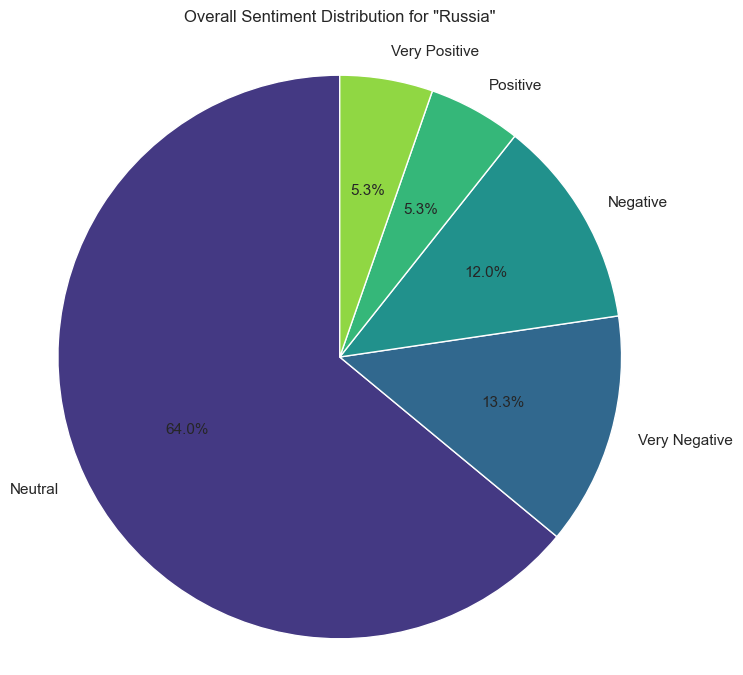


--- 2. Sentiment Trend Over Time for 'Russia' ---


C:\Users\dansi\AppData\Local\Temp\ipykernel_1680\4170104845.py:100: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_sentiment_trend = df_target_entity_trend['cont_score'].dropna().resample('M').mean() # Monthly average
d:\git\UnnamedProject\venv311\lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


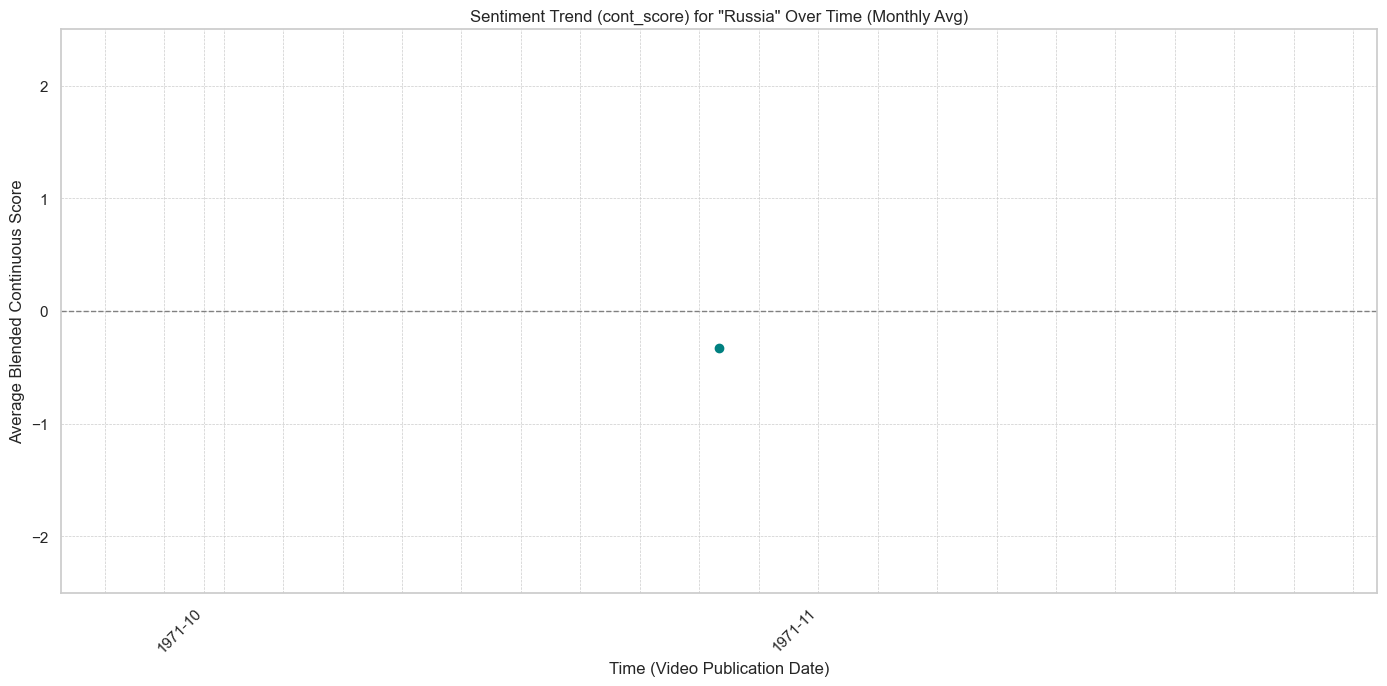


--- 3. Example Snippets for 'Russia' (Top 5 by cont_score) ---
  Video: Russia launches largest air attack yet on Ukraine | BBC News... (Published: 2025-05-25)
  Sentiment Score: 0.71
  Snippet: "Russia has intensified its strikes on Ukraine with the highest number of drones and missiles launched in a single night yet."

  Video: Moscow Slams Ukraine, Europe For ‘Provoking' War, Blocking P... (Published: 2025-05-27)
  Sentiment Score: 0.46
  Snippet: "That in effect means that Kiev is now free to strike targets inside Russia."

  Video: Moscow Slams Ukraine, Europe For ‘Provoking' War, Blocking P... (Published: 2025-05-27)
  Sentiment Score: 0.32
  Snippet: "Ukraine is also now allowed to strike deep inside Russia with the front lines shifting and rhetoric heating up."

  Video: Russia is working on creating a 'buffer zone' along Ukrainia... (Published: 2025-05-27)
  Sentiment Score: 0.24
  Snippet: "For Ukrainian President Vodimir Zalinski, keeping the weapons flowing is key to Ukrai

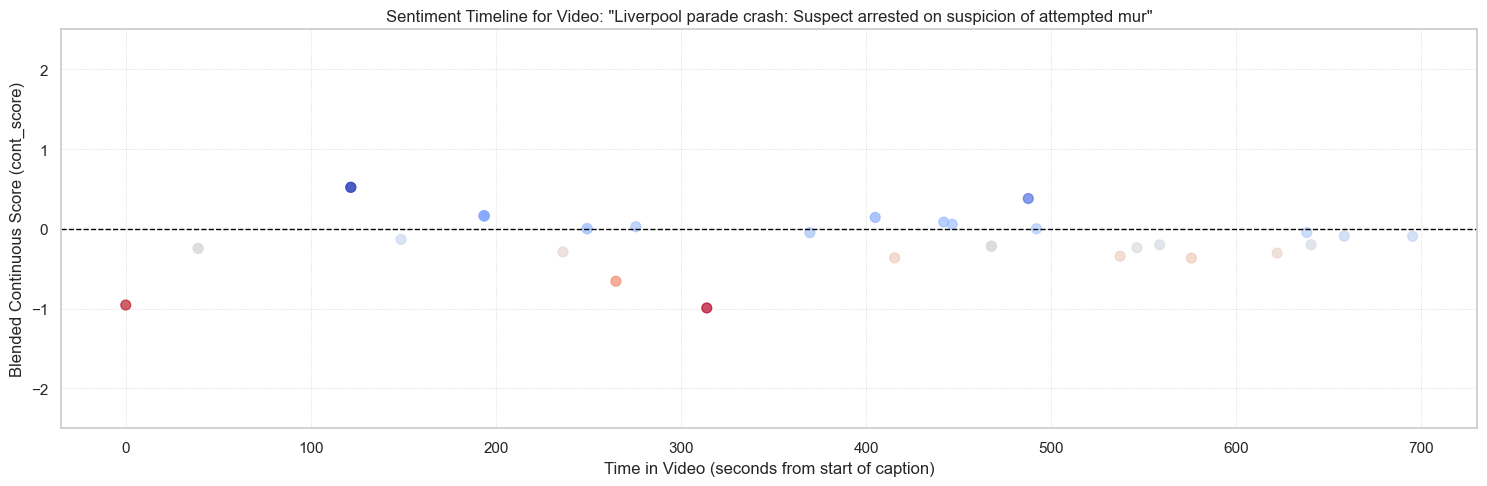


--- 2. Key Entities & Sentiments in Video 'be3lkHuj1pM' ---


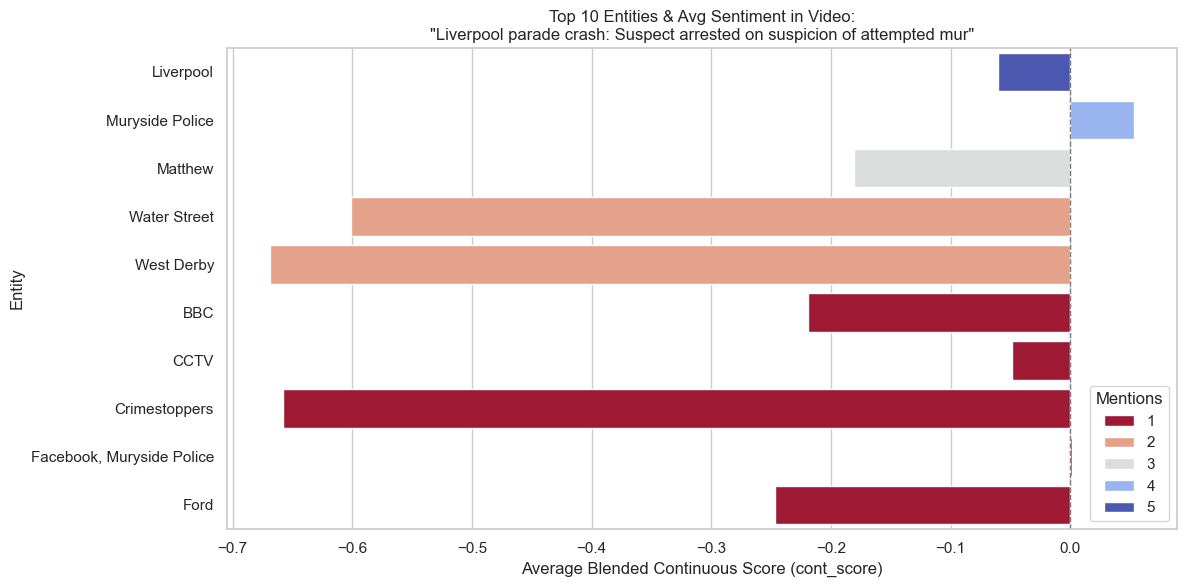



--- III. PLATFORM-WIDE / DISCOVERY ---

--- 1. Top 15 Most Mentioned Entities (Platform-wide) ---


C:\Users\dansi\AppData\Local\Temp\ipykernel_1680\4170104845.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_top_entities.values, y=platform_top_entities.index, palette="mako")


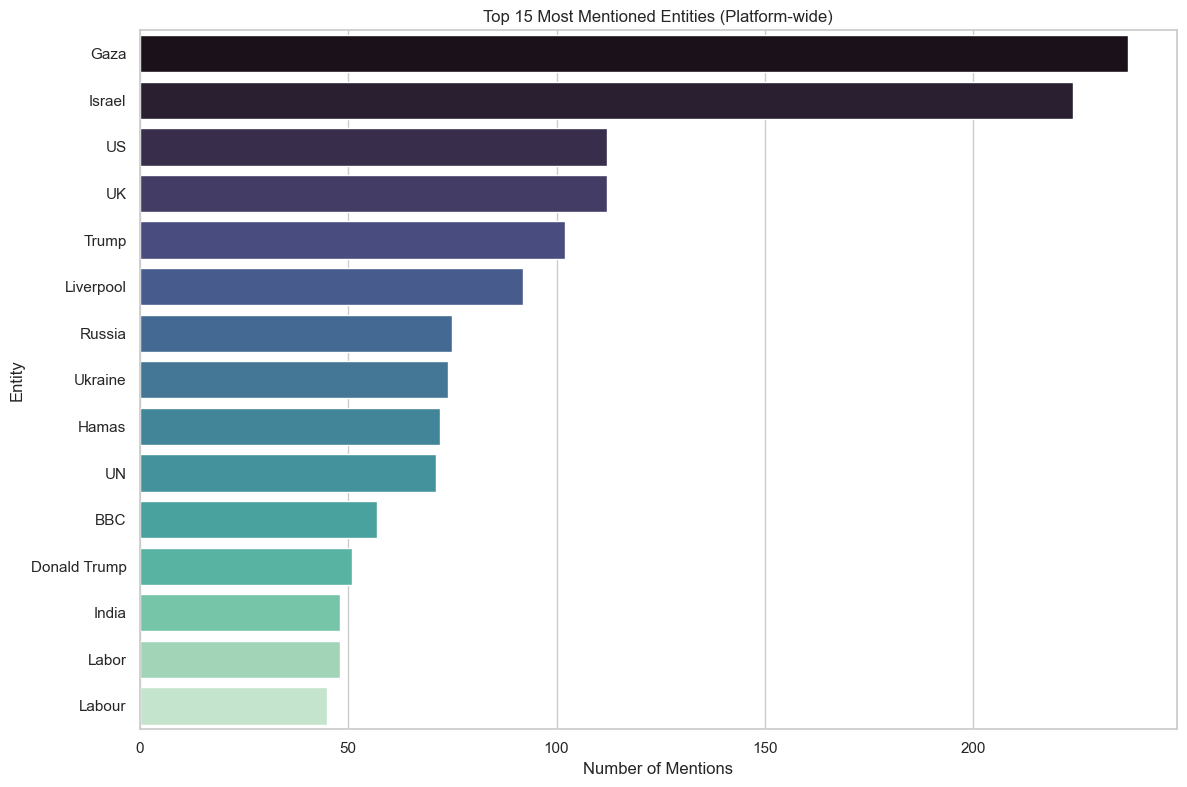


Visualization cell finished.


In [6]:
# Cell: MVP Visualize Entity Sentiment Data

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sqlalchemy import select, func, text # Added text for potential raw queries
from collections import Counter

# --- Assuming 'session' is your active SQLAlchemy session from Cell 1 ---
# --- Assuming 'Video', 'Caption', 'EntitySentiment' are imported from your models.py ---
# from models import Video, EntitySentiment, Caption # Ensure these are imported

# --- Configuration for Plots ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Adjusted default size
plt.rcParams['font.size'] = 11
N_TOP_ENTITIES_GLOBAL = 15 # Number of top entities for platform-wide plots
N_TOP_ENTITIES_VIDEO = 10  # Number of top entities within a single video

# --- SIMULATE USER INPUT / SELECTION ---
# In a real app, these would come from user searches or clicks.
# Change these to test different entities and videos from your database.
TARGET_ENTITY_FOR_ANALYSIS = "Russia" # Example entity
TARGET_VIDEO_ID_FOR_ANALYSIS = "be3lkHuj1pM" # Example video_id (use one you know has data)

# --- 1. Fetch Base Data ---
# We'll fetch data as needed for specific plots to keep it manageable.
# For entity trend over time, we need video publish dates.
print("Fetching initial data for visualizations...")
try:
    # For entity trend and some general stats
    stmt_full_data = (
        select(
            EntitySentiment.video_id,
            EntitySentiment.entity,
            EntitySentiment.sentiment,
            EntitySentiment.cont_score,
            EntitySentiment.start.label("caption_start"), # for video timeline
            EntitySentiment.duration.label("caption_duration"), # for video timeline
            Video.published_at.label("video_published_at"),
            Video.title.label("video_title"),
            Caption.text.label("caption_text") # For displaying snippets
        )
        .join(Video, EntitySentiment.video_id == Video.video_id)
        .join(Caption, EntitySentiment.caption_id == Caption.caption_id) # Join to get caption text
    )
    df_full_sentiments = pd.read_sql_query(stmt_full_data, session.bind)
    session.commit() 

    if not df_full_sentiments.empty:
        df_full_sentiments['video_published_at'] = pd.to_datetime(df_full_sentiments['video_published_at'])
        # Ensure caption_start is numeric for plotting
        df_full_sentiments['caption_start'] = pd.to_numeric(df_full_sentiments['caption_start'], errors='coerce')

    print(f"Fetched {len(df_full_sentiments)} entity sentiment records with video and caption details.")

except Exception as e:
    session.rollback()
    print(f"Error fetching data: {e}")
    df_full_sentiments = pd.DataFrame()

if df_full_sentiments.empty:
    print("No sentiment data to visualize. Exiting visualization cell.")
else:
    print(f"\nTarget entity for detailed analysis: {TARGET_ENTITY_FOR_ANALYSIS}")
    print(f"Target video for detailed analysis: {TARGET_VIDEO_ID_FOR_ANALYSIS}")

    # ==============================================================================
    # I. ENTITY-CENTRIC VISUALIZATIONS (for TARGET_ENTITY_FOR_ANALYSIS)
    # ==============================================================================
    print(f"\n\n--- I. ENTITY-CENTRIC ANALYSIS for: {TARGET_ENTITY_FOR_ANALYSIS} ---")
    df_target_entity = df_full_sentiments[df_full_sentiments['entity'].str.lower() == TARGET_ENTITY_FOR_ANALYSIS.lower()].copy()

    if df_target_entity.empty:
        print(f"No data found for entity: {TARGET_ENTITY_FOR_ANALYSIS}")
    else:
        # 1. Overall Sentiment Breakdown for the Target Entity
        print(f"\n--- 1. Overall Sentiment Breakdown for '{TARGET_ENTITY_FOR_ANALYSIS}' ---")
        plt.figure(figsize=(8, 8))
        sentiment_counts = df_target_entity['sentiment'].value_counts()
        if not sentiment_counts.empty:
            plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
                    startangle=90, colors=sns.color_palette("viridis", len(sentiment_counts)))
            plt.title(f'Overall Sentiment Distribution for "{TARGET_ENTITY_FOR_ANALYSIS}"', pad=20)
            plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
            plt.show()
        else:
            print(f"No sentiment categories found for '{TARGET_ENTITY_FOR_ANALYSIS}'.")

        # 2. Sentiment Trend Over Time for the Target Entity
        print(f"\n--- 2. Sentiment Trend Over Time for '{TARGET_ENTITY_FOR_ANALYSIS}' ---")
        if 'video_published_at' in df_target_entity.columns:
            df_target_entity_trend = df_target_entity.copy()
            df_target_entity_trend.set_index('video_published_at', inplace=True)
            
            # Resample by week or month for a smoother trend. Use 'W' for weekly, 'M' for monthly.
            # Ensure cont_score is numeric
            df_target_entity_trend['cont_score'] = pd.to_numeric(df_target_entity_trend['cont_score'], errors='coerce')
            avg_sentiment_trend = df_target_entity_trend['cont_score'].dropna().resample('M').mean() # Monthly average

            if not avg_sentiment_trend.empty:
                plt.figure(figsize=(14, 7))
                avg_sentiment_trend.plot(marker='o', linestyle='-', color='teal')
                plt.title(f'Sentiment Trend (cont_score) for "{TARGET_ENTITY_FOR_ANALYSIS}" Over Time (Monthly Avg)')
                plt.xlabel('Time (Video Publication Date)')
                plt.ylabel('Average Blended Continuous Score')
                plt.axhline(0, color='grey', lw=1, linestyle='--')
                plt.ylim(-2.5, 2.5) # Assuming cont_score is roughly in -2 to +2 range
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(avg_sentiment_trend) // 10))) # Adjust interval
                plt.xticks(rotation=45, ha='right')
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Not enough data points to plot sentiment trend for '{TARGET_ENTITY_FOR_ANALYSIS}'.")
        else:
            print("Column 'video_published_at' not found for trend analysis.")

        # 3. Relevant Video Snippets/Sentences for the Target Entity (Textual Output)
        print(f"\n--- 3. Example Snippets for '{TARGET_ENTITY_FOR_ANALYSIS}' (Top 5 by cont_score) ---")
        top_snippets = df_target_entity.nlargest(5, 'cont_score')[['video_title', 'caption_text', 'cont_score', 'video_published_at']]
        if not top_snippets.empty:
            for _, row in top_snippets.iterrows():
                print(f"  Video: {row['video_title'][:60]}... (Published: {row['video_published_at'].strftime('%Y-%m-%d')})")
                print(f"  Sentiment Score: {row['cont_score']:.2f}")
                print(f"  Snippet: \"{row['caption_text']}\"\n")
        else:
            print(f"No snippets found for '{TARGET_ENTITY_FOR_ANALYSIS}'.")

    # ==============================================================================
    # II. VIDEO-CENTRIC VISUALIZATIONS (for TARGET_VIDEO_ID_FOR_ANALYSIS)
    # ==============================================================================
    print(f"\n\n--- II. VIDEO-CENTRIC ANALYSIS for Video ID: {TARGET_VIDEO_ID_FOR_ANALYSIS} ---")
    df_target_video = df_full_sentiments[df_full_sentiments['video_id'] == TARGET_VIDEO_ID_FOR_ANALYSIS].copy()

    if df_target_video.empty:
        print(f"No data found for video_id: {TARGET_VIDEO_ID_FOR_ANALYSIS}")
    else:
        video_title_for_plot = df_target_video['video_title'].iloc[0] if not df_target_video.empty else "Unknown Title"
        print(f"Video Title: \"{video_title_for_plot}\"")

        # 1. Sentiment Arc/Timeline for the Target Video
        print(f"\n--- 1. Sentiment Timeline for Video '{TARGET_VIDEO_ID_FOR_ANALYSIS}' ---")
        df_video_timeline = df_target_video.sort_values(by='caption_start').dropna(subset=['caption_start', 'cont_score'])
        if not df_video_timeline.empty:
            plt.figure(figsize=(15, 5))
            # Create a color mapping for sentiment scores
            norm = plt.Normalize(df_video_timeline['cont_score'].min(), df_video_timeline['cont_score'].max())
            cmap = plt.get_cmap('coolwarm_r') # coolwarm_r: red for negative, blue for positive
            colors = cmap(norm(df_video_timeline['cont_score']))

            plt.scatter(df_video_timeline['caption_start'], df_video_timeline['cont_score'], c=colors, alpha=0.7, s=50)
            # Optional: connect points with a line if desired, but scatter shows individual caption sentiments
            # plt.plot(df_video_timeline['caption_start'], df_video_timeline['cont_score'], marker='o', linestyle='-', color='gray', alpha=0.5)

            plt.title(f'Sentiment Timeline for Video: "{video_title_for_plot[:70]}"')
            plt.xlabel('Time in Video (seconds from start of caption)')
            plt.ylabel('Blended Continuous Score (cont_score)')
            plt.axhline(0, color='black', lw=1, linestyle='--')
            plt.ylim(-2.5, 2.5)
            plt.grid(True, which='both', linestyle=':', linewidth=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Not enough caption data with timing to plot sentiment timeline for video '{TARGET_VIDEO_ID_FOR_ANALYSIS}'.")

        # 2. Key Entities in the Target Video and Their Sentiments
        print(f"\n--- 2. Key Entities & Sentiments in Video '{TARGET_VIDEO_ID_FOR_ANALYSIS}' ---")
        entities_in_video = df_target_video.groupby('entity')['cont_score'].agg(['mean', 'count']).reset_index()
        entities_in_video.rename(columns={'mean': 'avg_cont_score', 'count': 'mention_count'}, inplace=True)
        top_entities_in_video = entities_in_video.nlargest(N_TOP_ENTITIES_VIDEO, 'mention_count')

        if not top_entities_in_video.empty:
            plt.figure(figsize=(12, max(6, len(top_entities_in_video) * 0.5))) # Dynamic height
            sns.barplot(data=top_entities_in_video, y='entity', x='avg_cont_score', hue='mention_count',
                        palette="coolwarm_r", dodge=False, orient='h')
            plt.title(f'Top {N_TOP_ENTITIES_VIDEO} Entities & Avg Sentiment in Video:\n"{video_title_for_plot[:70]}"')
            plt.xlabel('Average Blended Continuous Score (cont_score)')
            plt.ylabel('Entity')
            plt.axvline(0, color='grey', lw=1, linestyle='--')
            plt.legend(title='Mentions', loc='lower right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No entities found to display for video '{TARGET_VIDEO_ID_FOR_ANALYSIS}'.")


    # ==============================================================================
    # III. PLATFORM-WIDE / DISCOVERY VISUALIZATIONS
    # ==============================================================================
    print(f"\n\n--- III. PLATFORM-WIDE / DISCOVERY ---")

    # 1. Top N Most Mentioned Entities (Platform-wide)
    print(f"\n--- 1. Top {N_TOP_ENTITIES_GLOBAL} Most Mentioned Entities (Platform-wide) ---")
    platform_top_entities = df_full_sentiments['entity'].value_counts().nlargest(N_TOP_ENTITIES_GLOBAL)
    if not platform_top_entities.empty:
        plt.figure(figsize=(12, 8))
        sns.barplot(x=platform_top_entities.values, y=platform_top_entities.index, palette="mako")
        plt.title(f'Top {N_TOP_ENTITIES_GLOBAL} Most Mentioned Entities (Platform-wide)')
        plt.xlabel('Number of Mentions')
        plt.ylabel('Entity')
        plt.tight_layout()
        plt.show()
    else:
        print("No entities found for platform-wide top mentions plot.")

    # Note: Trending Entities (requires comparing data over time periods) is more complex
    # and omitted for this MVP but is a valuable addition for a full app.

print("\nVisualization cell finished.")

In [ ]:
import os
import re
import json
import requests
import psycopg2

from psycopg2.extras import RealDictCursor, execute_values
from youtube_transcript_api import YouTubeTranscriptApi
import yt_dlp

class YouTubeDBPipeline:
    VTT_RE = re.compile(r"(\d+):(\d{2}):(\d{2}\.\d+)\s-->\s(\d+):(\d{2}):(\d{2}\.\d+)")
    YT_BASE = "https://www.googleapis.com/youtube/v3"

    def __init__(self):
        # -- Env/config
        self.api_key    = os.environ['YOUTUBE_API_KEY']
        self.channel_id = os.environ['CHANNEL_ID']
        # -- DB connection
        self.conn = psycopg2.connect(
            host   = os.environ['PGHOST'],
            port   = int(os.environ.get('PGPORT', 5432)),
            dbname = os.environ['PGDATABASE'],
            user   = os.environ['PGUSER'],
            password = os.environ['PGPASSWORD'],
        )

    # ---- YouTube API calls ----

    def fetch_search_ids(self, max_results=50):
        url = (
            f"{self.YT_BASE}/search"
            f"?part=snippet"
            f"&channelId={self.channel_id}"
            f"&order=date"
            f"&maxResults={max_results}"
            f"&type=video"
            f"&key={self.api_key}"
        )
        items = requests.get(url).json().get('items', [])
        return [itm['id']['videoId'] for itm in items]

    def fetch_video_details(self, video_ids):
        parts = ",".join([
            "snippet", "contentDetails", "statistics",
            "status", "player", "topicDetails",
            "recordingDetails", "liveStreamingDetails", "localizations"
        ])
        url = (
            f"{self.YT_BASE}/videos"
            f"?part={parts}"
            f"&id={','.join(video_ids)}"
            f"&key={self.api_key}"
        )
        return requests.get(url).json().get('items', [])

    # ---- Local VTT parsing ----

    def extract_vtt(self, path):
        segments = []
        buf = []
        start = end = None

        def flush():
            nonlocal buf, start, end
            if buf and start is not None and end is not None:
                text = " ".join(buf).strip()
                if text:
                    segments.append((start, end - start, len(text.split())))
            buf = []; start = end = None

        with open(path, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if m := self.VTT_RE.match(line):
                    flush()
                    h1,m1,s1,h2,m2,s2 = m.groups()
                    start = int(h1)*3600 + int(m1)*60 + float(s1)
                    end   = int(h2)*3600 + int(m2)*60 + float(s2)
                else:
                    clean = re.sub(r"<.*?>", "", line)
                    if clean:
                        buf.append(clean)
            flush()
        return segments

    def fetch_captions(self, video_id):
        # try Transcript API
        try:
            raw = YouTubeTranscriptApi.get_transcript(video_id)
            source = "YouTubeTranscriptApi"
            segs = [(s['start'], s['duration'], len(s['text'].split())) for s in raw]
        except Exception:
            # fallback to yt-dlp .vtt
            vtt = f"{video_id}.en.vtt"
            if not os.path.exists(vtt):
                ydl_opts = {
                    "skip_download": True,
                    "writesubtitles": True,
                    "writeautomaticsub": True,
                    "subtitleslangs": ["en"],
                    "subtitlesformat": "vtt",
                    "outtmpl": f"{video_id}.%(ext)s",
                    "quiet": True
                }
                with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                    ydl.download([f"https://youtube.com/watch?v={video_id}"])
            if os.path.exists(vtt):
                segs = self.extract_vtt(vtt)
                os.remove(vtt)
                source = "yt_dlp"
            else:
                return [], "none"

        return segs, source

    # ---- DB upsert routines ----

    def upsert_channel(self, snippet):
        with self.conn.cursor() as cur:
            cur.execute("""
                INSERT INTO channels(id,title,thumbnail_url)
                VALUES (%s,%s,%s)
                ON CONFLICT(id) DO UPDATE
                  SET title = EXCLUDED.title,
                      thumbnail_url = EXCLUDED.thumbnail_url
            """, (
                snippet['channelId'],
                snippet['channelTitle'],
                snippet['thumbnails']['high']['url'],
            ))

    def upsert_videos(self, items):
        sql = """
        INSERT INTO videos(
          id, channel_id, title, description,
          published_at, duration, tags,
          stats_json, metadata_json, caption_source
        ) VALUES %s
        ON CONFLICT(id) DO UPDATE
          SET title         = EXCLUDED.title,
              description   = EXCLUDED.description,
              published_at  = EXCLUDED.published_at,
              duration      = EXCLUDED.duration,
              tags          = EXCLUDED.tags,
              stats_json    = EXCLUDED.stats_json,
              metadata_json = EXCLUDED.metadata_json,
              caption_source= EXCLUDED.caption_source
        """
        rows = []
        for itm in items:
            rows.append((
                itm['id'],
                itm['snippet']['channelId'],
                itm['snippet']['title'],
                itm['snippet'].get('description'),
                itm['snippet']['publishedAt'],
                itm['contentDetails']['duration'],
                itm['snippet'].get('tags', []),
                json.dumps(itm.get('statistics', {})),
                json.dumps(itm),
                None
            ))
        with self.conn.cursor() as cur:
            execute_values(cur, sql, rows)

    def upsert_captions(self, video_id: str, segments: list[tuple], source: str):
        """
        Inserts each (start, duration, word_count) for video_id,
        then updates the caption_source on the videos table.
        """
        with self.conn.cursor() as cur:
            # 1) Bulk‐insert caption segments
            if segments:
                # Prepend video_id to each segment tuple
                rows = [
                    (video_id, start, duration, word_count)
                    for start, duration, word_count in segments
                ]
                execute_values(
                    cur,
                    """
                    INSERT INTO caption_segments(video_id, start_s, duration_s, word_count)
                    VALUES %s
                    ON CONFLICT (video_id, start_s) DO NOTHING
                    """,
                    rows
                )

            # 2) Update the video's caption_source
            cur.execute(
                "UPDATE videos SET caption_source = %s WHERE id = %s",
                (source, video_id)
            )

    # ---- Orchestration ----

    def load_all(self):
        # 1) Search & details
        video_ids = self.fetch_search_ids()
        details   = self.fetch_video_details(video_ids)
        if not details:
            raise RuntimeError("YouTube API returned no video items.")

        # 2) Upsert channel (all share same snippet.channelId)
        self.upsert_channel(details[0]['snippet'])
        # 3) Upsert videos
        self.upsert_videos(details)

        # 4) Upsert captions per video
        for vid in video_ids:
            segs, src = self.fetch_captions(vid)
            self.upsert_captions(vid, segs, src)

        self.conn.commit()

    def dump_json_from_db(self, limit=50):
        """Read back exactly the same structure that Script 1 produced."""
        with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT v.id AS video_id,
                       v.metadata_json AS metadata,
                       v.caption_source
                FROM videos v
                WHERE v.channel_id = %s
                ORDER BY v.published_at DESC
                LIMIT %s
            """, (self.channel_id, limit))
            vids = cur.fetchall()

        all_data = []
        for rec in vids:
            # fetch segments
            with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
                cur.execute("""
                    SELECT
                    start_s::float   AS start,
                    duration_s::float AS duration,
                    word_count
                    FROM caption_segments
                    WHERE video_id = %s
                    ORDER BY start_s
                """, (rec['video_id'],))
                caps = cur.fetchall()

            all_data.append({
                "video_id":      rec['video_id'],
                "metadata":      rec['metadata'],
                "captions":      caps,
                "caption_source": rec['caption_source'],
            })
        return all_data

    def close(self):
        self.conn.close()


def main():
    pipeline = YouTubeDBPipeline()
    try:
        # this will always fetch & store the latest 50 + captions
        pipeline.load_all()

        # then read back from your DB and dump JSON
        output = pipeline.dump_json_from_db()
        with open("latest_videos_with_metadata_and_captions.json", "w", encoding="utf-8") as f:
            json.dump(output, f, indent=2, ensure_ascii=False)

        print(f"Saved {len(output)} videos' metadata and captions to 'latest_videos_with_metadata_and_captions.json'")
    finally:
        pipeline.close()


if __name__ == "__main__":
    main()


Saved 50 videos' metadata and captions to 'latest_videos_with_metadata_and_captions.json'


In [ ]:
import os
import re
import json
import requests
import psycopg2

from psycopg2.extras import RealDictCursor, execute_values
from youtube_transcript_api import YouTubeTranscriptApi
import yt_dlp

class YouTubeDBPipeline:
    VTT_RE = re.compile(r"(\d+):(\d{2}):(\d{2}\.\d+)\s-->\s(\d+):(\d{2}):(\d{2}\.\d+)")
    YT_BASE = "https://www.googleapis.com/youtube/v3"

    def __init__(self):
        # -- Env/config
        self.api_key    = os.environ['YOUTUBE_API_KEY']
        self.channel_id = os.environ['CHANNEL_ID']
        # -- DB connection
        self.conn = psycopg2.connect(
            host   = os.environ['PGHOST'],
            port   = int(os.environ.get('PGPORT', 5432)),
            dbname = os.environ['PGDATABASE'],
            user   = os.environ['PGUSER'],
            password = os.environ['PGPASSWORD'],
        )

    # ---- YouTube API calls ----

    def fetch_search_ids(self, max_results=50):
        url = (
            f"{self.YT_BASE}/search"
            f"?part=snippet"
            f"&channelId={self.channel_id}"
            f"&order=date"
            f"&maxResults={max_results}"
            f"&type=video"
            f"&key={self.api_key}"
        )
        items = requests.get(url).json().get('items', [])
        return [itm['id']['videoId'] for itm in items]

    def fetch_video_details(self, video_ids):
        parts = ",".join([
            "snippet", "contentDetails", "statistics",
            "status", "player", "topicDetails",
            "recordingDetails", "liveStreamingDetails", "localizations"
        ])
        url = (
            f"{self.YT_BASE}/videos"
            f"?part={parts}"
            f"&id={','.join(video_ids)}"
            f"&key={self.api_key}"
        )
        return requests.get(url).json().get('items', [])

    # ---- Local VTT parsing ----

    def extract_vtt(self, path):
        segments = []
        buf = []
        start = end = None

        def flush():
            nonlocal buf, start, end
            if buf and start is not None and end is not None:
                text = " ".join(buf).strip()
                if text:
                    segments.append((start, end - start, len(text.split())))
            buf = []; start = end = None

        with open(path, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if m := self.VTT_RE.match(line):
                    flush()
                    h1,m1,s1,h2,m2,s2 = m.groups()
                    start = int(h1)*3600 + int(m1)*60 + float(s1)
                    end   = int(h2)*3600 + int(m2)*60 + float(s2)
                else:
                    clean = re.sub(r"<.*?>", "", line)
                    if clean:
                        buf.append(clean)
            flush()
        return segments

    def fetch_captions(self, video_id):
        # try Transcript API
        try:
            raw = YouTubeTranscriptApi.get_transcript(video_id)
            source = "YouTubeTranscriptApi"
            segs = [(s['start'], s['duration'], len(s['text'].split())) for s in raw]
        except Exception:
            # fallback to yt-dlp .vtt
            vtt = f"{video_id}.en.vtt"
            if not os.path.exists(vtt):
                ydl_opts = {
                    "skip_download": True,
                    "writesubtitles": True,
                    "writeautomaticsub": True,
                    "subtitleslangs": ["en"],
                    "subtitlesformat": "vtt",
                    "outtmpl": f"{video_id}.%(ext)s",
                    "quiet": True
                }
                with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                    ydl.download([f"https://youtube.com/watch?v={video_id}"])
            if os.path.exists(vtt):
                segs = self.extract_vtt(vtt)
                os.remove(vtt)
                source = "yt_dlp"
            else:
                return [], "none"

        return segs, source

    # ---- DB upsert routines ----

    def upsert_channel(self, snippet):
        with self.conn.cursor() as cur:
            cur.execute("""
                INSERT INTO channels(id,title,thumbnail_url)
                VALUES (%s,%s,%s)
                ON CONFLICT(id) DO UPDATE
                  SET title = EXCLUDED.title,
                      thumbnail_url = EXCLUDED.thumbnail_url
            """, (
                snippet['channelId'],
                snippet['channelTitle'],
                snippet['thumbnails']['high']['url'],
            ))

    def upsert_videos(self, items):
        sql = """
        INSERT INTO videos(
          id, channel_id, title, description,
          published_at, duration, tags,
          stats_json, metadata_json, caption_source
        ) VALUES %s
        ON CONFLICT(id) DO UPDATE
          SET title         = EXCLUDED.title,
              description   = EXCLUDED.description,
              published_at  = EXCLUDED.published_at,
              duration      = EXCLUDED.duration,
              tags          = EXCLUDED.tags,
              stats_json    = EXCLUDED.stats_json,
              metadata_json = EXCLUDED.metadata_json,
              caption_source= EXCLUDED.caption_source
        """
        rows = []
        for itm in items:
            rows.append((
                itm['id'],
                itm['snippet']['channelId'],
                itm['snippet']['title'],
                itm['snippet'].get('description'),
                itm['snippet']['publishedAt'],
                itm['contentDetails']['duration'],
                itm['snippet'].get('tags', []),
                json.dumps(itm.get('statistics', {})),
                json.dumps(itm),
                None
            ))
        with self.conn.cursor() as cur:
            execute_values(cur, sql, rows)

    def upsert_captions(self, video_id: str, segments: list[tuple], source: str):
        """
        Inserts each (start, duration, word_count) for video_id,
        then updates the caption_source on the videos table.
        """
        with self.conn.cursor() as cur:
            # 1) Bulk‐insert caption segments
            if segments:
                # Prepend video_id to each segment tuple
                rows = [
                    (video_id, start, duration, word_count)
                    for start, duration, word_count in segments
                ]
                execute_values(
                    cur,
                    """
                    INSERT INTO caption_segments(video_id, start_s, duration_s, word_count)
                    VALUES %s
                    ON CONFLICT (video_id, start_s) DO NOTHING
                    """,
                    rows
                )

            # 2) Update the video's caption_source
            cur.execute(
                "UPDATE videos SET caption_source = %s WHERE id = %s",
                (source, video_id)
            )

    # ---- Orchestration ----

    def load_all(self):
        # 1) Search & details
        video_ids = self.fetch_search_ids()
        details   = self.fetch_video_details(video_ids)
        if not details:
            raise RuntimeError("YouTube API returned no video items.")

        # 2) Upsert channel (all share same snippet.channelId)
        self.upsert_channel(details[0]['snippet'])
        # 3) Upsert videos
        self.upsert_videos(details)

        # 4) Upsert captions per video
        for vid in video_ids:
            segs, src = self.fetch_captions(vid)
            self.upsert_captions(vid, segs, src)

        self.conn.commit()

    def dump_json_from_db(self, limit=50):
        """Read back exactly the same structure that Script 1 produced."""
        with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT v.id AS video_id,
                       v.metadata_json AS metadata,
                       v.caption_source
                FROM videos v
                WHERE v.channel_id = %s
                ORDER BY v.published_at DESC
                LIMIT %s
            """, (self.channel_id, limit))
            vids = cur.fetchall()

        all_data = []
        for rec in vids:
            # fetch segments
            with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
                cur.execute("""
                    SELECT
                    start_s::float   AS start,
                    duration_s::float AS duration,
                    word_count
                    FROM caption_segments
                    WHERE video_id = %s
                    ORDER BY start_s
                """, (rec['video_id'],))
                caps = cur.fetchall()

            all_data.append({
                "video_id":      rec['video_id'],
                "metadata":      rec['metadata'],
                "captions":      caps,
                "caption_source": rec['caption_source'],
            })
        return all_data

    def close(self):
        self.conn.close()


def main():
    pipeline = YouTubeDBPipeline()
    try:
        # this will always fetch & store the latest 50 + captions
        pipeline.load_all()

        # then read back from your DB and dump JSON
        output = pipeline.dump_json_from_db()
        with open("latest_videos_with_metadata_and_captions.json", "w", encoding="utf-8") as f:
            json.dump(output, f, indent=2, ensure_ascii=False)

        print(f"Saved {len(output)} videos' metadata and captions to 'latest_videos_with_metadata_and_captions.json'")
    finally:
        pipeline.close()


if __name__ == "__main__":
    main()


Saved 50 videos' metadata and captions to 'latest_videos_with_metadata_and_captions.json'


In [ ]:
import os
import re
import json
import requests
import psycopg2

from psycopg2.extras import RealDictCursor, execute_values
from youtube_transcript_api import YouTubeTranscriptApi
import yt_dlp

class YouTubeDBPipeline:
    VTT_RE = re.compile(r"(\d+):(\d{2}):(\d{2}\.\d+)\s-->\s(\d+):(\d{2}):(\d{2}\.\d+)")
    YT_BASE = "https://www.googleapis.com/youtube/v3"

    def __init__(self):
        # -- Env/config
        self.api_key    = os.environ['YOUTUBE_API_KEY']
        self.channel_id = os.environ['CHANNEL_ID']
        # -- DB connection
        self.conn = psycopg2.connect(
            host   = os.environ['PGHOST'],
            port   = int(os.environ.get('PGPORT', 5432)),
            dbname = os.environ['PGDATABASE'],
            user   = os.environ['PGUSER'],
            password = os.environ['PGPASSWORD'],
        )

    # ---- YouTube API calls ----

    def fetch_search_ids(self, max_results=50):
        url = (
            f"{self.YT_BASE}/search"
            f"?part=snippet"
            f"&channelId={self.channel_id}"
            f"&order=date"
            f"&maxResults={max_results}"
            f"&type=video"
            f"&key={self.api_key}"
        )
        items = requests.get(url).json().get('items', [])
        return [itm['id']['videoId'] for itm in items]

    def fetch_video_details(self, video_ids):
        parts = ",".join([
            "snippet", "contentDetails", "statistics",
            "status", "player", "topicDetails",
            "recordingDetails", "liveStreamingDetails", "localizations"
        ])
        url = (
            f"{self.YT_BASE}/videos"
            f"?part={parts}"
            f"&id={','.join(video_ids)}"
            f"&key={self.api_key}"
        )
        return requests.get(url).json().get('items', [])

    # ---- Local VTT parsing ----

    def extract_vtt(self, path):
        segments = []
        buf = []
        start = end = None

        def flush():
            nonlocal buf, start, end
            if buf and start is not None and end is not None:
                text = " ".join(buf).strip()
                if text:
                    segments.append((start, end - start, len(text.split())))
            buf = []; start = end = None

        with open(path, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if m := self.VTT_RE.match(line):
                    flush()
                    h1,m1,s1,h2,m2,s2 = m.groups()
                    start = int(h1)*3600 + int(m1)*60 + float(s1)
                    end   = int(h2)*3600 + int(m2)*60 + float(s2)
                else:
                    clean = re.sub(r"<.*?>", "", line)
                    if clean:
                        buf.append(clean)
            flush()
        return segments

    def fetch_captions(self, video_id):
        # try Transcript API
        try:
            raw = YouTubeTranscriptApi.get_transcript(video_id)
            source = "YouTubeTranscriptApi"
            segs = [(s['start'], s['duration'], len(s['text'].split())) for s in raw]
        except Exception:
            # fallback to yt-dlp .vtt
            vtt = f"{video_id}.en.vtt"
            if not os.path.exists(vtt):
                ydl_opts = {
                    "skip_download": True,
                    "writesubtitles": True,
                    "writeautomaticsub": True,
                    "subtitleslangs": ["en"],
                    "subtitlesformat": "vtt",
                    "outtmpl": f"{video_id}.%(ext)s",
                    "quiet": True
                }
                with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                    ydl.download([f"https://youtube.com/watch?v={video_id}"])
            if os.path.exists(vtt):
                segs = self.extract_vtt(vtt)
                os.remove(vtt)
                source = "yt_dlp"
            else:
                return [], "none"

        return segs, source

    # ---- DB upsert routines ----

    def upsert_channel(self, snippet):
        with self.conn.cursor() as cur:
            cur.execute("""
                INSERT INTO channels(id,title,thumbnail_url)
                VALUES (%s,%s,%s)
                ON CONFLICT(id) DO UPDATE
                  SET title = EXCLUDED.title,
                      thumbnail_url = EXCLUDED.thumbnail_url
            """, (
                snippet['channelId'],
                snippet['channelTitle'],
                snippet['thumbnails']['high']['url'],
            ))

    def upsert_videos(self, items):
        sql = """
        INSERT INTO videos(
          id, channel_id, title, description,
          published_at, duration, tags,
          stats_json, metadata_json, caption_source
        ) VALUES %s
        ON CONFLICT(id) DO UPDATE
          SET title         = EXCLUDED.title,
              description   = EXCLUDED.description,
              published_at  = EXCLUDED.published_at,
              duration      = EXCLUDED.duration,
              tags          = EXCLUDED.tags,
              stats_json    = EXCLUDED.stats_json,
              metadata_json = EXCLUDED.metadata_json,
              caption_source= EXCLUDED.caption_source
        """
        rows = []
        for itm in items:
            rows.append((
                itm['id'],
                itm['snippet']['channelId'],
                itm['snippet']['title'],
                itm['snippet'].get('description'),
                itm['snippet']['publishedAt'],
                itm['contentDetails']['duration'],
                itm['snippet'].get('tags', []),
                json.dumps(itm.get('statistics', {})),
                json.dumps(itm),
                None
            ))
        with self.conn.cursor() as cur:
            execute_values(cur, sql, rows)

    def upsert_captions(self, video_id: str, segments: list[tuple], source: str):
        """
        Inserts each (start, duration, word_count) for video_id,
        then updates the caption_source on the videos table.
        """
        with self.conn.cursor() as cur:
            # 1) Bulk‐insert caption segments
            if segments:
                # Prepend video_id to each segment tuple
                rows = [
                    (video_id, start, duration, word_count)
                    for start, duration, word_count in segments
                ]
                execute_values(
                    cur,
                    """
                    INSERT INTO caption_segments(video_id, start_s, duration_s, word_count)
                    VALUES %s
                    ON CONFLICT (video_id, start_s) DO NOTHING
                    """,
                    rows
                )

            # 2) Update the video's caption_source
            cur.execute(
                "UPDATE videos SET caption_source = %s WHERE id = %s",
                (source, video_id)
            )

    # ---- Orchestration ----

    def load_all(self):
        # 1) Search & details
        video_ids = self.fetch_search_ids()
        details   = self.fetch_video_details(video_ids)
        if not details:
            raise RuntimeError("YouTube API returned no video items.")

        # 2) Upsert channel (all share same snippet.channelId)
        self.upsert_channel(details[0]['snippet'])
        # 3) Upsert videos
        self.upsert_videos(details)

        # 4) Upsert captions per video
        for vid in video_ids:
            segs, src = self.fetch_captions(vid)
            self.upsert_captions(vid, segs, src)

        self.conn.commit()

    def dump_json_from_db(self, limit=50):
        """Read back exactly the same structure that Script 1 produced."""
        with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute("""
                SELECT v.id AS video_id,
                       v.metadata_json AS metadata,
                       v.caption_source
                FROM videos v
                WHERE v.channel_id = %s
                ORDER BY v.published_at DESC
                LIMIT %s
            """, (self.channel_id, limit))
            vids = cur.fetchall()

        all_data = []
        for rec in vids:
            # fetch segments
            with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
                cur.execute("""
                    SELECT
                    start_s::float   AS start,
                    duration_s::float AS duration,
                    word_count
                    FROM caption_segments
                    WHERE video_id = %s
                    ORDER BY start_s
                """, (rec['video_id'],))
                caps = cur.fetchall()

            all_data.append({
                "video_id":      rec['video_id'],
                "metadata":      rec['metadata'],
                "captions":      caps,
                "caption_source": rec['caption_source'],
            })
        return all_data

    def close(self):
        self.conn.close()


def main():
    pipeline = YouTubeDBPipeline()
    try:
        # this will always fetch & store the latest 50 + captions
        pipeline.load_all()

        # then read back from your DB and dump JSON
        output = pipeline.dump_json_from_db()
        with open("latest_videos_with_metadata_and_captions.json", "w", encoding="utf-8") as f:
            json.dump(output, f, indent=2, ensure_ascii=False)

        print(f"Saved {len(output)} videos' metadata and captions to 'latest_videos_with_metadata_and_captions.json'")
    finally:
        pipeline.close()


if __name__ == "__main__":
    main()


Saved 50 videos' metadata and captions to 'latest_videos_with_metadata_and_captions.json'
